In [1]:
library(dplyr)
library(ggplot2)
library(lemon)
library(gridExtra)
library(gtable)
library(egg)

eval_file = '/labs/shahlab/projects/agataf/data/cohorts/pooled_cohorts/experiments/bmj_review/bootstrap_standard_eval_logit1_fixed.csv'
preds0 <- read.csv(eval_file)

# TODO: with newest version of Stephen's repo, do I still need to make
# those transformations? Can I do them when I run the bootstrap?

# TODO: make this cleaner

# Step 1: transform metrics generated by the bootstrap evaluation 
# to metrics we'd like to plot
preds <- bind_rows(preds0, 
                      preds0 %>%
                        filter(metric=='tce_logit') %>% 
                        mutate(
                             CI_med = CI_med*-1, 
                               CI_lower_new = CI_upper*-1,
                               CI_upper = CI_lower*-1,
                               CI_lower = CI_lower_new,
                               metric='threshold_error',
                                
                        yline=0),
                       preds0 %>% 
                        filter(metric=='sensitivity' | metric=='specificity') %>% 
                        mutate(CI_med = 1-CI_med, 
                               CI_lower_new = 1-CI_upper,
                               CI_upper = 1-CI_lower,
                               CI_lower = CI_lower_new,
                               metric=ifelse(metric=='sensitivity', 'fnr', 
                                              ifelse(metric=='specificity', 'fpr', NA_real_)))

                      )

# TODO: make this switch happen in the bootstrap file.
# Update names to those we'd like to plot
df_to_plot <- preds %>% 
              mutate(group = as.character(group),
                     metric_full_name = recode(metric, 
                                               fnr='False Negative Rate',
                                               fpr='False Positive Rate',
                                     sensitivity = "Sensitivity", 
                                     specificity = "Specificity",
                                     #impl_threshold_log = "Implied\nThreshold", 
                                     threshold_error = "Threshold Calibration Error",
                                     auc = "AUROC",
                                     loss = "Cross Entropy Loss",
                                     ace_logit = "Abs. Calibration Error", 
                                     ace_bin = "Binned ACE",
                                     auprc="AUPRC"), #%>% 
                      threshold = paste("t =", as.character(thresholds*100), "%") %>% 
                                  factor(levels=c("t = 7.5 %", "t = 20 %")),
                      model_type = recode(model_type, EO3='EO')
                     
                    )



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Warning message:
“package ‘gridExtra’ was built under R version 3.6.3”
Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine

Warning message:
“package ‘egg’ was built under R version 3.6.3”Warning message in bind_rows_(x, .id):
“binding factor and character vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”

In [11]:
make_grid_plot <- function(
    df,
    col_vars,
    grid_rows = 1,
    aspect_ratio = 1,
    y_axis_breaks = seq(-0.1,1,0.1)
) {
    g <- ggplot(
            data=df, aes(model_type, CI_med, color=group)
         ) + 
         geom_point(
            position=position_dodge(width=0.75), size=2
         ) +
         geom_linerange(
             aes(ymin = CI_lower, ymax = CI_upper),
             size = 1,
             position = position_dodge(width = 0.75)
         ) + 
         facet_grid(
             rows = grid_rows,
             cols = col_vars,
                   scales = "free",
         ) +
         theme_bw(
         ) + 
         theme(
             axis.title = element_text(size = rel(2.5)),
             axis.title.y = element_blank(),
             axis.title.x = element_blank(),
             strip.text.x = element_text(size = rel(2)),
             strip.text.y = element_text(size = rel(1.9)),
             strip.background = element_blank(),
             strip.placement = "outside",
             axis.text.x = element_text(angle = 45, vjust=0.95, hjust=1),
             axis.text = element_text(size=rel(1.2), color='black'),
             axis.line = element_line(color='black'),
             #legend.text=element_text(size=rel(1.2)),
             #legend.title=element_text(size=rel(1.2)),
             legend.position='bottom',
             aspect.ratio=aspect_ratio
         ) +
         labs(
             y = 'Performance',
             color = "Group"
         ) +
         scale_color_manual(
             labels = c("Black women", 
                        "non-Black women", 
                        "Black men", 
                        "non-Black men",
                        "Overall"),                
             values = c("red", 
                        "green",
                        "orange",
                        "blue", 
                        "black")
         ) +
         geom_hline(
             aes(yintercept = yline),
             color = 'black', 
             linetype = 'dashed', 
             size = 0.5, 
             alpha = 0.5
         ) +
         scale_y_continuous(
             breaks = y_axis_breaks
         )
    
    return(g)
    
}



Warning message:
“Removed 50 rows containing missing values (geom_hline).”Saving 6.67 x 6.67 in image
Warning message:
“Removed 50 rows containing missing values (geom_hline).”Warning message:
“Removed 100 rows containing missing values (geom_hline).”

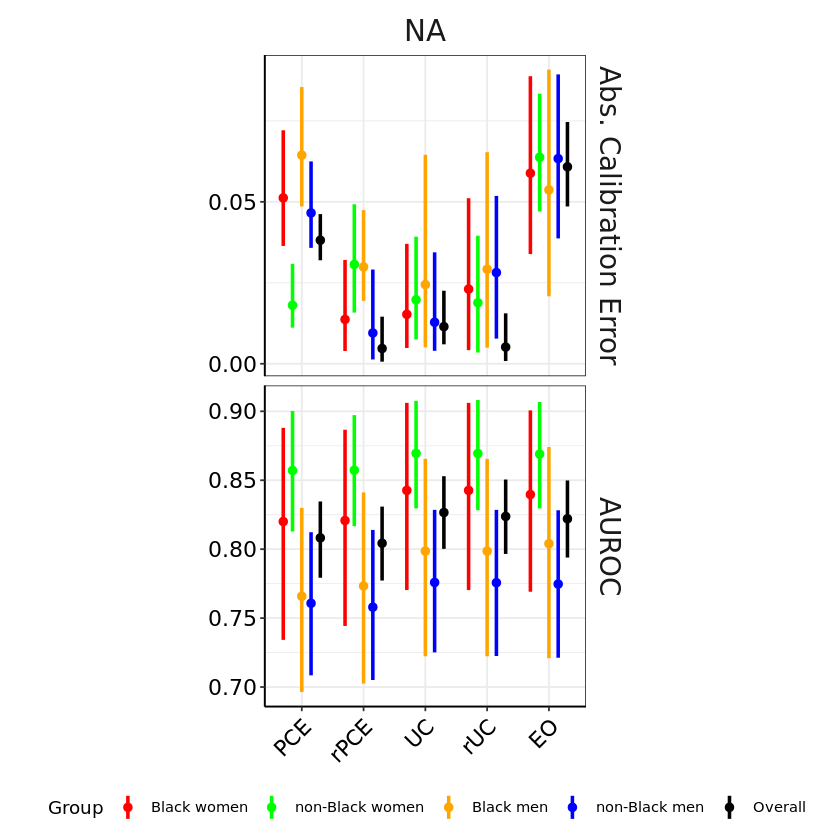

Saving 6.67 x 6.67 in image
Warning message:
“Removed 100 rows containing missing values (geom_hline).”

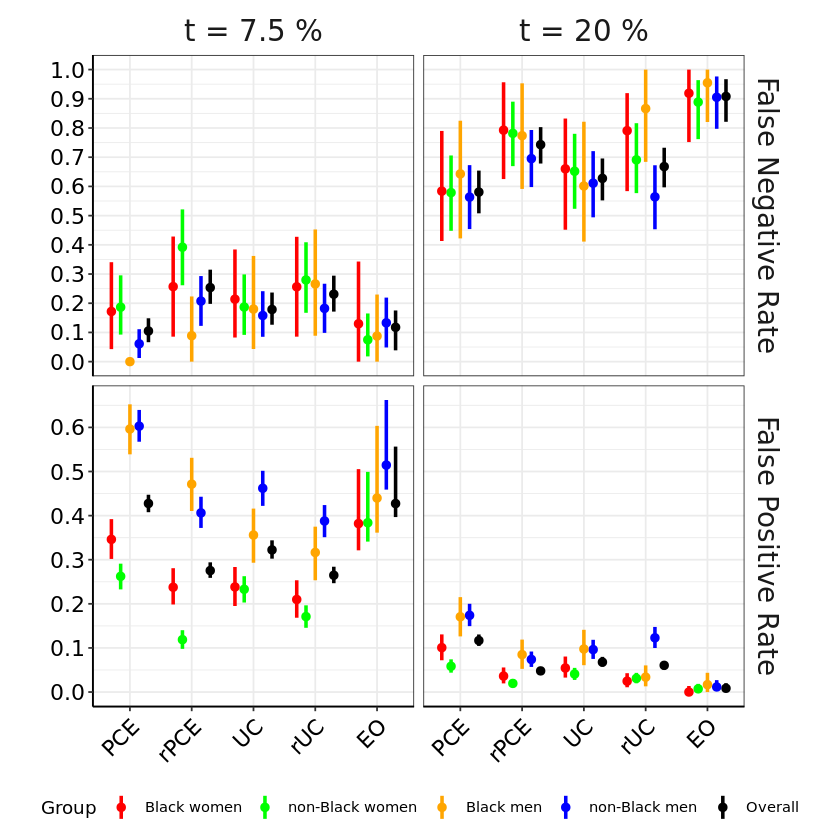

Saving 6.67 x 6.67 in image


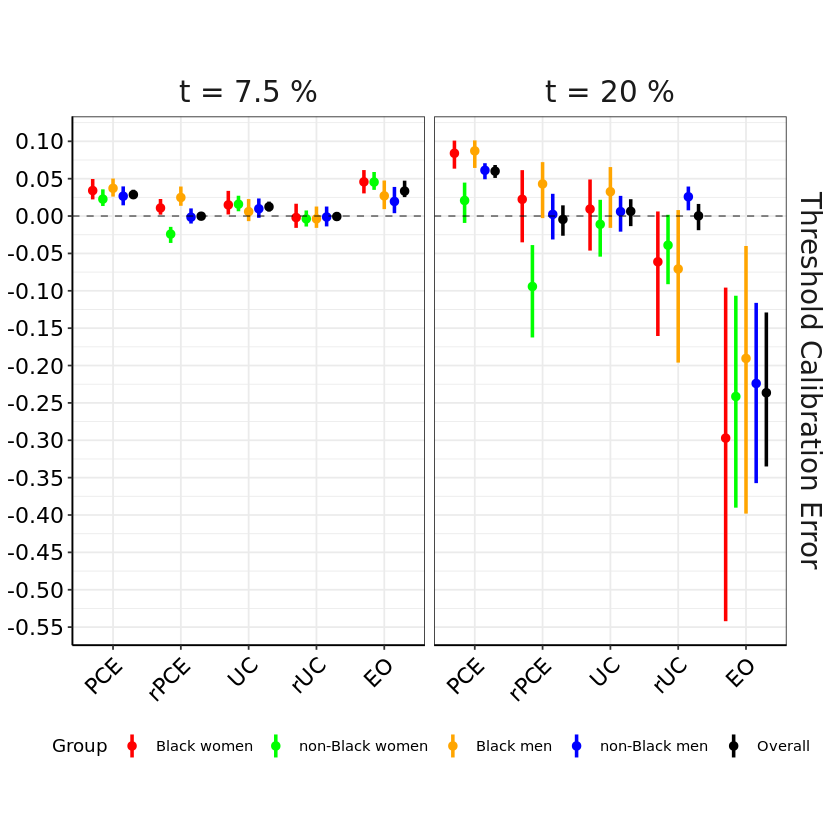

In [18]:
# Generate figure 3

# select only EO3 for plotting, which corresponds to the model
# with lambda=0.464
models_fig3 = c("PCE", "rPCE", "UC", "rUC", "EO")
one_eo <- df_to_plot %>% 

              filter(
                  model_type %in% models_fig3
              ) %>%

              mutate(
                  model_type = factor(model_type, levels=models_fig3)
              ) 

# figure 3a
gen_metrics <- one_eo %>% filter(metric=='auc'| metric=='ace_logit')
make_grid_plot(df            = gen_metrics, 
               col_vars      = vars(thresholds), 
               grid_rows     = vars(metric_full_name), 
               aspect_ratio  = 1, 
               # TODO: adjust for top and bottom separately
               y_axis_breaks = seq(-0.1,1,0.05)
              )
ggsave(filename = 'figures/fig3a.jpeg', 
       device='jpeg', dpi=700)

# figure 3b
sens_spec <- one_eo %>% filter(metric=='fnr' | metric=='fpr')
thr_err <- one_eo %>% filter(metric=="threshold_error")

make_grid_plot(df = sens_spec,
               col_vars = vars(threshold),
               grid_rows = vars(metric_full_name), 
               aspect_ratio = 1)

ggsave(filename = 'figures/fig3b-1.jpeg', 
       device='jpeg', dpi=700)


make_grid_plot(df = thr_err, 
               col_vars=vars(threshold), 
               grid_rows = vars(metric_full_name),
               aspect_ratio = 1.5, 
               y_axis_breaks = seq(-0.55,1,0.05))

ggsave(filename = 'figures/fig3b-2.jpeg', 
       device='jpeg', dpi=700)



Warning message:
“Removed 40 rows containing missing values (geom_hline).”Saving 6.67 x 6.67 in image
Warning message:
“Removed 40 rows containing missing values (geom_hline).”Warning message:
“Removed 80 rows containing missing values (geom_hline).”

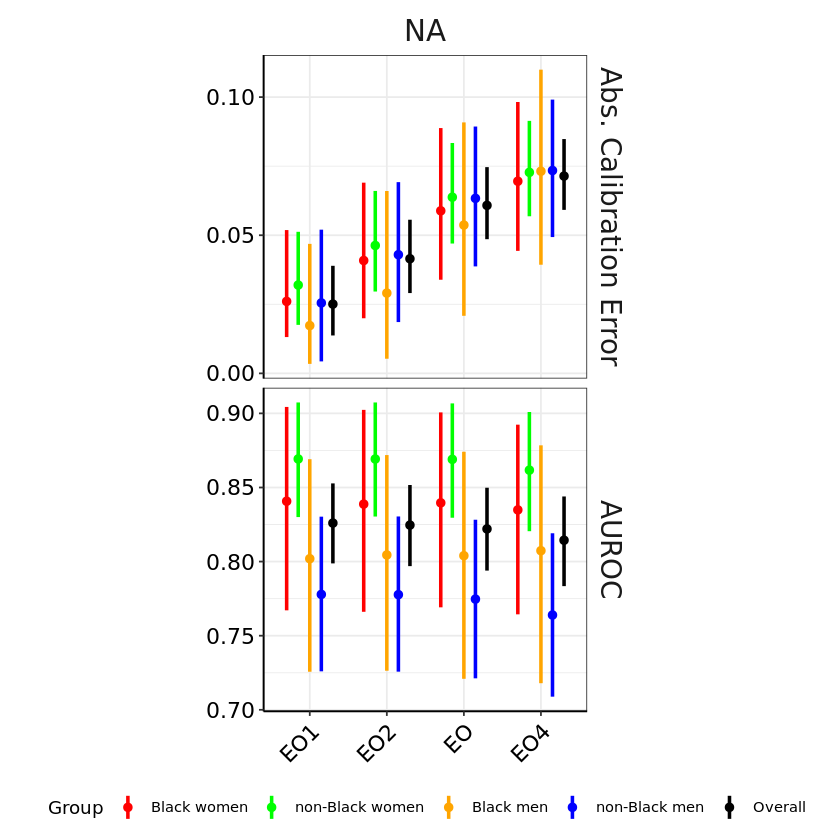

Saving 6.67 x 6.67 in image
Warning message:
“Removed 80 rows containing missing values (geom_hline).”

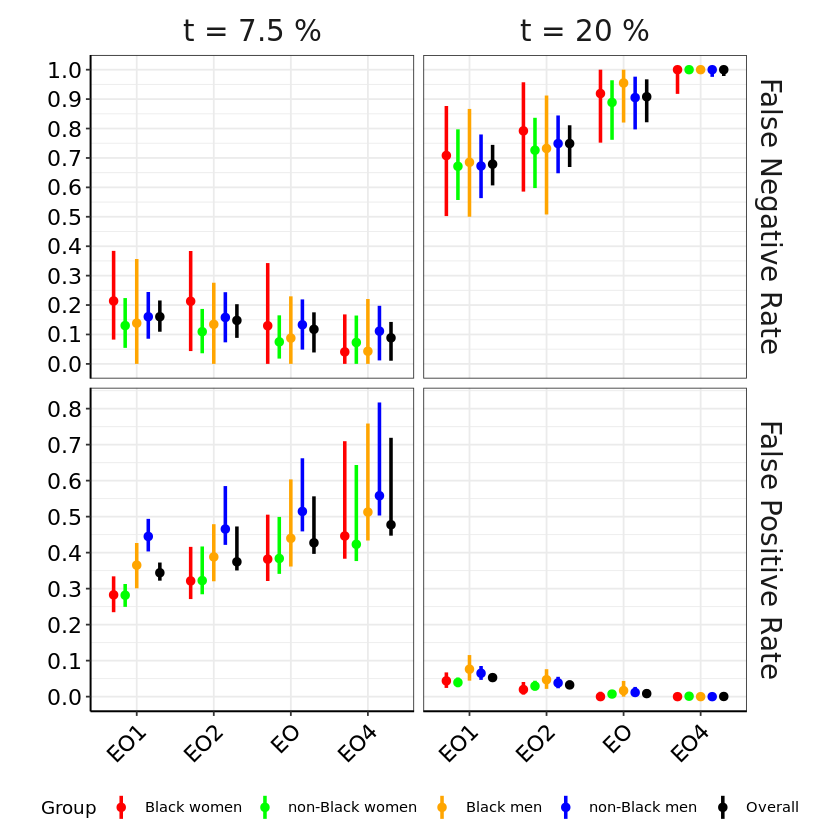

Saving 6.67 x 6.67 in image


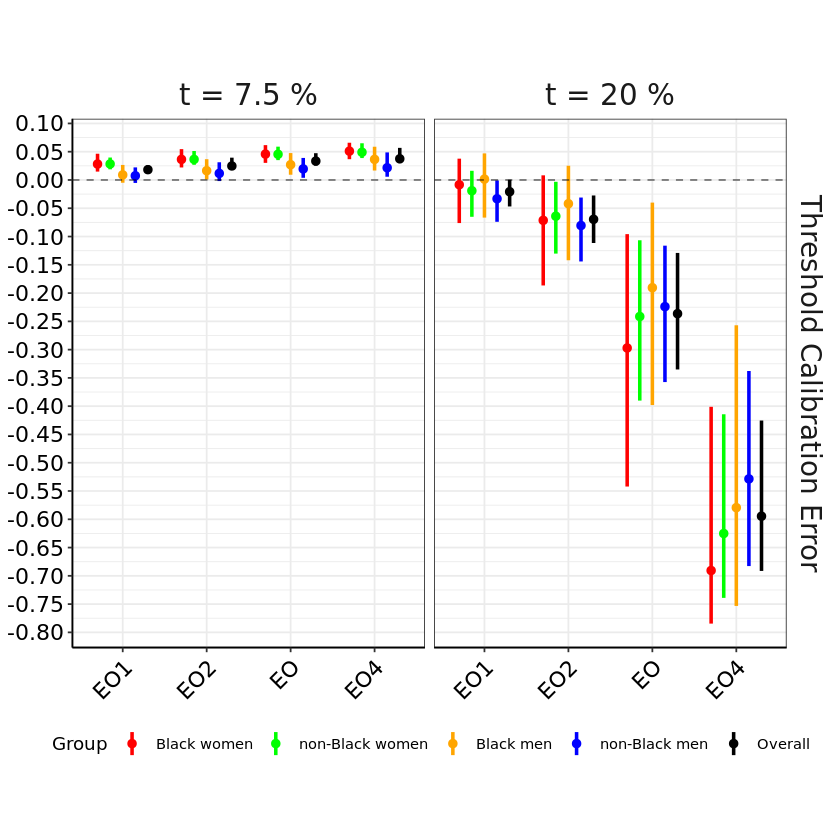

In [16]:
# Generate Supplementary figure B2

chosen_models = c("EO1",  "EO2",  "EO",  "EO4")
# select only EO models for plotting
one_eo <- df_to_plot %>% 
            filter(
                model_type %in% chosen_models
            ) %>%  
            mutate(
                model_type = factor(model_type, levels = chosen_models)
            )

# Supplementary figure B2-a
gen_metrics <- one_eo %>% filter(metric=='auc'| metric=='ace_logit')
make_grid_plot(df            = gen_metrics, 
               col_vars      = vars(thresholds), 
               grid_rows     = vars(metric_full_name), 
               aspect_ratio  = 1, 
               y_axis_breaks = seq(-0.1,1,0.05)
              )
ggsave(filename = 'figures/SuppB-fig2a.jpeg', 
       device='jpeg', dpi=700)

# figure B2-b
sens_spec <- one_eo %>% filter(metric=='fnr' | metric=='fpr')
thr_err <- one_eo %>% filter(metric=="threshold_error")

make_grid_plot(df = sens_spec,
               col_vars = vars(threshold),
               grid_rows = vars(metric_full_name), 
               aspect_ratio = 1)

ggsave(filename = 'figures/SuppB-fig2b-1.jpeg', 
       device='jpeg', dpi=700)


make_grid_plot(df = thr_err, 
               col_vars=vars(threshold), 
               grid_rows = vars(metric_full_name),
               aspect_ratio = 1.5, 
               y_axis_breaks = seq(-0.8,1,0.05))

ggsave(filename = 'figures/SuppB-fig2b-2.jpeg', 
       device='jpeg', dpi=700)

